# Setup

In [ ]:
!pip install scikit-learn==0.24
!pip install scikit-optimize
!pip install Boruta

     |████████████████████████████████| 22.3 MB 1.2 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


     |████████████████████████████████| 56 kB 1.0 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib as jb
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score, f1_score, precision_recall_curve, confusion_matrix
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import backend as K
from xgboost import XGBClassifier
from skopt import gp_minimize
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from tensorflow.python.client import device_lib
 
def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

In [ ]:
PATH = "/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/"
APPROACH = 8

# Make Datasets

In [ ]:
def get_data(path):
  predictions = []
  names = []
  for idx, file_name in enumerate(os.listdir(path)):
    if file_name.endswith(".z"):
      names.append("{}/{}".format(path, file_name))
      predictions.append(jb.load(names[-1]))
 
  return names, predictions
 
def make_dataframe(names, data):
  array = np.zeros((data[0].shape[0], len(data)))
  for idx, pred in enumerate(data):
    if len(pred.shape) == 2:
      pred = transform_1d_array(pred)
    if len(pred) == data[0].shape[0]:
      array[:, idx] = pred
 
  return pd.DataFrame(data=array, columns=names)
 
def transform_1d_array(data):
  array = []
  for idx in range(data.shape[0]):
    array.append(data[idx][0])
 
  return np.array(array)

In [ ]:
train_names, train_pred = get_data("{}preds_train1/approach{}".format(PATH, APPROACH))
X_train = make_dataframe(train_names, train_pred)
X_train.head()

,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_train1/approach8/lgbm_837_184_646_0.006173770394704579.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_train1/approach8/lgbm_557_101_421_0.0010025956902289567.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_train1/approach8/lgbm_314_651_139_0.014655354118727714.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_train1/approach8/lgbm_951_2_795_0.007119418600172993.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_train1/approach8/lgbm_689_8_116_0.0037525283395739802.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_train1/approach8/lgbm_520_48_782_0.0004992453416923983.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_train1/approach8/lgbm_272_619_368_0.0890620438616169.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_train1/approach8/lgbm_573_860_576_0.0022464551680532606.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_train1/approach8/lgbm_211_942_494_0.00143301094556357.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_train1/approach8/lgbm_213_232_269_0.011214774784159465.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_train1/approach8/lgbm_200_163_800_0.00014012184416758864.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_train1/approach8/lgbm_1000_717_336_0.0009543042354083111.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_train1/approach8/lgbm_200_1000_800_0.0001.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_train1/approach8/lgbm_1000_950_133_0.05195862106159334.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_train1/approach8/lgbm_975_40_108_0.07601698337464463.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_train1/approach8/lgbm_985_996_132_0.08414410627459354.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_train1/approach8/lgbm_296_995_183_0.09993738234989769.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_train1/approach8/lgbm_753_945_800_0.09981056985871509.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_train1/approach8/lgbm_258_143_780_0.09889569306177969.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_train1/approach8/lgbm_200_1000_100_0.1.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_train1/approach8/lgbm_958_9_612_0.09917679409911188.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_train1/approach8/lgbm_1000_434_800_0.004411364145548578.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_train1/approach8/lgbm_200_331_100_0.0001.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_train1/approach8/lgbm_1000_853_100_0.008174327828701837.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_train1/approach8/lgbm_1000_460_588_0.004931665782713697.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_train1/approach8/lgbm_946_332_800_0.009836036038612557.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_train1/approach8/lgbm_1000_808_800_0.004275328619072725.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_train1/approach8/lgbm_1000_348_100_0.1.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_train1/approach8/lgbm_200_274_800_0.0015035239178601539.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_train1/approach8/lgbm_200_1_590_0.0001.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_train1/approach8/lgbm_1000_170_800_0.0003877442498365998.pkl.z,/content/drive/

In [ ]:
valid_names, valid_pred = get_data("{}preds_val1/approach{}".format(PATH, APPROACH))
X_valid = make_dataframe(valid_names, valid_pred)
X_valid.head()

,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_val1/approach8/lgbm_837_184_646_0.006173770394704579.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_val1/approach8/lgbm_557_101_421_0.0010025956902289567.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_val1/approach8/lgbm_314_651_139_0.014655354118727714.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_val1/approach8/lgbm_951_2_795_0.007119418600172993.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_val1/approach8/lgbm_689_8_116_0.0037525283395739802.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_val1/approach8/lgbm_520_48_782_0.0004992453416923983.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_val1/approach8/lgbm_272_619_368_0.0890620438616169.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_val1/approach8/lgbm_573_860_576_0.0022464551680532606.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_val1/approach8/lgbm_211_942_494_0.00143301094556357.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_val1/approach8/lgbm_213_232_269_0.011214774784159465.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_val1/approach8/lgbm_200_163_800_0.00014012184416758864.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_val1/approach8/lgbm_1000_717_336_0.0009543042354083111.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_val1/approach8/lgbm_200_1000_800_0.0001.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_val1/approach8/lgbm_1000_950_133_0.05195862106159334.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_val1/approach8/lgbm_975_40_108_0.07601698337464463.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_val1/approach8/lgbm_985_996_132_0.08414410627459354.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_val1/approach8/lgbm_296_995_183_0.09993738234989769.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_val1/approach8/lgbm_753_945_800_0.09981056985871509.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_val1/approach8/lgbm_258_143_780_0.09889569306177969.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_val1/approach8/lgbm_200_1000_100_0.1.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_val1/approach8/lgbm_958_9_612_0.09917679409911188.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_val1/approach8/lgbm_1000_434_800_0.004411364145548578.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_val1/approach8/lgbm_200_331_100_0.0001.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_val1/approach8/lgbm_1000_853_100_0.008174327828701837.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_val1/approach8/lgbm_1000_460_588_0.004931665782713697.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_val1/approach8/lgbm_946_332_800_0.009836036038612557.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_val1/approach8/lgbm_1000_808_800_0.004275328619072725.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_val1/approach8/lgbm_1000_348_100_0.1.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_val1/approach8/lgbm_200_274_800_0.0015035239178601539.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_val1/approach8/lgbm_200_1_590_0.0001.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_val1/approach8/lgbm_1000_170_800_0.0003877442498365998.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_val1/ap

In [ ]:
test_names, test_pred = get_data("{}preds_test/approach{}".format(PATH, APPROACH))
X_test = make_dataframe(test_names, test_pred)
X_test.head()

,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_test/approach8/lgbm_837_184_646_0.006173770394704579.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_test/approach8/lgbm_557_101_421_0.0010025956902289567.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_test/approach8/lgbm_314_651_139_0.014655354118727714.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_test/approach8/lgbm_951_2_795_0.007119418600172993.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_test/approach8/lgbm_689_8_116_0.0037525283395739802.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_test/approach8/lgbm_520_48_782_0.0004992453416923983.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_test/approach8/lgbm_272_619_368_0.0890620438616169.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_test/approach8/lgbm_573_860_576_0.0022464551680532606.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_test/approach8/lgbm_211_942_494_0.00143301094556357.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_test/approach8/lgbm_213_232_269_0.011214774784159465.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_test/approach8/lgbm_200_163_800_0.00014012184416758864.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_test/approach8/lgbm_1000_717_336_0.0009543042354083111.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_test/approach8/lgbm_200_1000_800_0.0001.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_test/approach8/lgbm_1000_950_133_0.05195862106159334.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_test/approach8/lgbm_975_40_108_0.07601698337464463.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_test/approach8/lgbm_985_996_132_0.08414410627459354.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_test/approach8/lgbm_296_995_183_0.09993738234989769.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_test/approach8/lgbm_753_945_800_0.09981056985871509.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_test/approach8/lgbm_258_143_780_0.09889569306177969.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_test/approach8/lgbm_200_1000_100_0.1.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_test/approach8/lgbm_958_9_612_0.09917679409911188.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_test/approach8/lgbm_1000_434_800_0.004411364145548578.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_test/approach8/lgbm_200_331_100_0.0001.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_test/approach8/lgbm_1000_853_100_0.008174327828701837.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_test/approach8/lgbm_1000_460_588_0.004931665782713697.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_test/approach8/lgbm_946_332_800_0.009836036038612557.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_test/approach8/lgbm_1000_808_800_0.004275328619072725.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_test/approach8/lgbm_1000_348_100_0.1.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_test/approach8/lgbm_200_274_800_0.0015035239178601539.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_test/approach8/lgbm_200_1_590_0.0001.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_test/approach8/lgbm_1000_170_800_0.0003877442498365998.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_test/ap

In [ ]:
APPROACH = 10

In [ ]:
name_ytrain1 = "{}preds_train1/approach{}/y.pkl.z".format(PATH, APPROACH)
if name_ytrain1 in X_train.columns:
  X_train.drop(name_ytrain1, axis=1, inplace=True)
X_train['y'] = jb.load(name_ytrain1)
name_yvalid = "{}preds_val1/approach{}/y.pkl.z".format(PATH, APPROACH)
if name_yvalid in X_valid.columns:
  X_valid.drop(name_yvalid, axis=1, inplace=True)
X_valid['y'] = jb.load(name_yvalid)
name_id = "{}preds_test/approach{}/id.pkl.z".format(PATH, APPROACH)
if name_id in X_test.columns:
  X_test.drop(name_id, axis=1, inplace=True)
X_test['id'] = jb.load(name_id).astype(np.int)

In [ ]:
X_train.to_csv("{}preds_train1/approach{}/train.csv".format(PATH, APPROACH), index=False)
X_valid.to_csv("{}preds_val1/approach{}/valid.csv".format(PATH, APPROACH), index=False)
X_test.to_csv("{}preds_test/approach{}/test.csv".format(PATH, APPROACH), index=False)

In [ ]:
X_test.head()

,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_test/approach16/xgb_0.001_30_20.0_0.5176340423475686_0.8897795283965984_1_100.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_test/approach16/xgb_0.001_26_9.481374117810043_1.0_0.7302788654322194_3_1000.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_test/approach16/xgb_0.001_21_0.14230187508727427_0.2_0.8361700572237387_2_1000.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_test/approach16/xgb_0.3393497650860792_8_0.010181479270291144_0.9028564990958987_0.8294523154450808_3_777.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_test/approach16/xgb_0.03455226492886329_20_2.931204260729689_0.8708180499261642_0.22290367755317272_2_619.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_test/approach16/xgb_0.6315226473914034_3_0.8584797439161793_0.7774800412758449_0.33558656854727076_3_838.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_test/approach16/xgb_0.8999999999999998_6_0.5417445673334125_0.9802263099980499_0.575209230436103_3_726.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_test/approach16/xgb_0.003660174691086067_12_0.2007183068742538_0.8175146062070187_0.9719511776058309_2_683.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_test/approach16/xgb_0.5353639708278544_18_0.016279651993879252_0.7338948041310325_0.22459609163240524_2_473.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_test/approach16/xgb_0.010783020047795177_6_0.056649551075328174_0.7511263405196669_0.2357586218727921_3_400.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_test/approach16/xgb_0.1968062643072061_5_8.858527883563013_0.6994011240277832_0.6090187349846994_3_526.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_test/approach16/xgb_0.8999999999999998_25_17.028631919339997_0.9254939444570047_0.35580326113545274_2_994.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_test/approach16/xgb_0.10894043954505213_8_0.01515341067731255_0.7328483839442801_0.517750711263246_2_544.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_test/approach16/xgb_0.001_10_1.0567506998816087_0.7054503751251533_0.5266392530691208_1_655.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_test/approach16/xgb_0.8835090923406186_10_1.025550469301756_0.6705415680399409_0.7775984342697067_2_880.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_test/approach16/xgb_0.004838275022121824_6_14.512585407011018_0.7217205887742597_0.5418980933702575_2_389.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_test/approach16/xgb_0.0015900160413960108_18_0.1901108281641761_0.3871155814377987_0.6804881867841472_3_827.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_test/approach16/xgb_0.00392824635159229_3_0.02607390464757199_0.49869108032448733_0.24618545122660535_3_839.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_test/approach16/xgb_0.0108728232425281_15_0.05392690713301055_0.32706220762498195_0.6570274138038725_2_843.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_test/approach16/xgb_0.09416498185959969_9_20.0_0.9152479755186824_0.37772176697736093_2_100.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_test/approach16/xgb_0.3423773406082189_3_3.765044279483292_0.2799864531450911_0.7733848730790451_2_1000.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_test/approach16/xgb_0.20462258548372209_3_0.032307833760149195_0.8249890630456207_0.6540279926969581_2_954.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_test/approach16/xgb_0.0773977914241749

# Load Data

In [ ]:
train_path = "{}preds_train1/approach{}".format(PATH, APPROACH)
valid_path = "{}preds_val1/approach{}".format(PATH, APPROACH)
test_path = "{}preds_test/approach{}".format(PATH, APPROACH)

In [ ]:
X_train = pd.read_csv("{}preds_train1/approach{}/train.csv".format(PATH, APPROACH))
X_valid = pd.read_csv("{}preds_val1/approach{}/valid.csv".format(PATH, APPROACH))
X_test = pd.read_csv("{}preds_test/approach{}/test.csv".format(PATH, APPROACH))

In [ ]:
y_train = X_train["y"].astype(np.float32)
y_valid = X_valid["y"].astype(np.float32)
test_id = X_test["id"]
X_train.drop(["y"], axis=1, inplace=True)
X_valid.drop(["y"], axis=1, inplace=True)
X_test.drop(["id"], axis=1, inplace=True)

In [ ]:
def get_common_columns(train_col, valid_col, test_col):
  common = []
  for col in train_col:
    file_name = col[len(train_path):]
    if valid_path + file_name in valid_col and test_path + file_name in test_col:
      common.append(file_name)
 
  return common

In [ ]:
mask = get_common_columns(X_train.columns, X_valid.columns, X_test.columns)

In [ ]:
len(mask), X_train.shape

(237, (3390, 238))

In [ ]:
X_train = X_train[[train_path + col for col in mask]]
X_valid = X_valid[[valid_path + col for col in mask]]
X_test = X_test[[test_path + col for col in mask]]

In [ ]:
X_test.head()

,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_test/approach16/xgb_0.001_30_20.0_0.5176340423475686_0.8897795283965984_1_100.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_test/approach16/xgb_0.001_21_0.14230187508727427_0.2_0.8361700572237387_2_1000.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_test/approach16/xgb_0.001_26_9.481374117810043_1.0_0.7302788654322194_3_1000.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_test/approach16/xgb_0.3393497650860792_8_0.010181479270291144_0.9028564990958987_0.8294523154450808_3_777.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_test/approach16/xgb_0.03455226492886329_20_2.931204260729689_0.8708180499261642_0.22290367755317272_2_619.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_test/approach16/xgb_0.003660174691086067_12_0.2007183068742538_0.8175146062070187_0.9719511776058309_2_683.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_test/approach16/xgb_0.6315226473914034_3_0.8584797439161793_0.7774800412758449_0.33558656854727076_3_838.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_test/approach16/xgb_0.8999999999999998_6_0.5417445673334125_0.9802263099980499_0.575209230436103_3_726.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_test/approach16/lr_default.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_test/approach16/lgbm_default.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_test/approach16/rf_default.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_test/approach16/xgboost_default.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_test/approach16/xgb_0.22551796937629706_8_3.7478601695703286_0.6774801263571897_0.556666202282873_1_513.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_test/approach16/xgb_0.009679572227018539_7_1.4079990864907204_0.24512926322168022_0.77759901781346_3_101.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_test/approach16/xgb_0.8535590410250283_20_1.044925745499645_0.20565304417577393_0.21844994003313262_2_460.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_test/approach16/xgb_0.0013736044401282768_29_0.058665824255262754_0.27248514762625664_0.69470880746647_2_985.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_test/approach16/xgb_0.02392934334166526_26_1.7608225490877036_0.5603994015756345_0.21061196892789324_3_607.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_test/approach16/xgb_0.01375985367791632_3_0.05783456110984593_0.39282037282080945_0.7466108150603668_2_850.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_test/approach16/xgb_0.0032520800635385434_14_0.03995460045412452_0.8042891282541222_0.5401246995929958_1_611.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_test/approach16/xgb_0.0012373913042111905_26_0.30524733778066404_0.5161201888014517_0.9413270926350357_2_394.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_test/approach16/xgb_0.04844286703435268_17_14.888730997782599_0.8756270789425213_0.7978560881099048_2_628.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_test/approach16/xgb_0.7105559184561583_19_0.08148573338727381_0.437018804563266_0.33221355125040203_1_481.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_test/approach16/xgb_0.001_30_20.0_1.0_0.2_1_1000.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_test/approach16/xgb_0.15613480801849933_19_12.789683596538854_1.0_0.8016869269542226_1_1000.pkl.z,/content/drive/MyDrive/Colab Notebooks/Porto_Seguro_competition/preds_test/approach16/xgb_

# Functions for metric

In [ ]:
def evaluate(y_pred, y_true, plot_matrix=True):
    score = precision_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    if plot_matrix:
        conf_matrix = confusion_matrix(y_true, y_pred)
        plt.matshow(conf_matrix, cmap=plt.cm.gray)
        plt.show()
    return score, f1
 
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds, thrh):
    plt.figure(figsize=(8, 4))
    plt.axis([0, 1.1, 0, 1])
    precision_by_thrs = precisions[np.argmax(thresholds == thrh)]
    recall_by_thrs = recalls[np.argmax(thresholds == thrh)]
    
    plt.plot([thrh, thrh], [0., precision_by_thrs], "r:")
    plt.plot([thrh, thrh], [0., recall_by_thrs], "r:")
    plt.plot([0, thrh], [precision_by_thrs, precision_by_thrs], "r:")
    plt.plot([0, thrh], [recall_by_thrs, recall_by_thrs], "r:")
    plt.plot([thrh], [precision_by_thrs], "ro")        
    plt.plot([thrh], [recall_by_thrs], "ro")   
    
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")    
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.legend(loc="center right", fontsize=14)
    plt.xlabel("Threshold")
    plt.ylabel("Value")
    plt.grid(True)
    
def better_threshold(precisions, recalls, thresholds):
    f1_best = 0
    threshold = 0
    for i in range(len(precisions)):
        if precisions[i] != 0 and recalls[i] != 0:
            f1 = 2*(precisions[i]*recalls[i])/(precisions[i] + recalls[i])
        else:
            f1 = 0
        if f1 > f1_best:
            f1_best = f1
            threshold = thresholds[i]
            
    
    return threshold, f1_best

# Features selection

In [ ]:
selected_rg = ['/xgb_0.1462035497632611_3_0.7960204883545489_0.8746194250678412_0.2_2_380.pkl.z',
               '/lgbm_669_135_220_0.05446342360286173.pkl.z',
               '/lgbm_375_406_800_0.017244763906930197.pkl.z',
               '/xgb_0.15613480801849933_19_12.789683596538854_1.0_0.8016869269542226_1_1000.pkl.z',
               '/nn_dropout_480_118_0.740706450259131_0.5670076500491628_32_1.584710121043908e-05.pkl.z',
               '/rf_default.pkl.z']

In [ ]:
# best_score = dist.max() + 1e-4
# dist = np.array([0,0])
best_score = 0
for col in mask:
  if col not in selected_rg:
    Xtr = X_train[[train_path + col for col in selected_rg] + [train_path + col]].copy()
    Xval = X_valid[[valid_path + col for col in selected_rg] + [valid_path + col]].copy()

    mdl = Ridge(alpha=1.)
    mdl.fit(Xtr, y_train)
    p = mdl.predict(Xtr)
    precisions, recalls, thresholds = precision_recall_curve(y_train, p)
    thrs, _ = better_threshold(precisions, recalls, thresholds)
    p = mdl.predict(Xval)

    y_pred = (p>= thrs).astype(int)
    _, c = evaluate(y_pred, y_valid, plot_matrix=False)
    if c > best_score:
      if c > dist.max() + 1e-4:
        print("Selected: ", col, c)
        print()
      else:
        print(col, c)
        print()
      best_score = c

/xgb_0.001_30_20.0_0.5176340423475686_0.8897795283965984_1_100.pkl.z 0.6736292428198434

/xgb_0.001_26_9.481374117810043_1.0_0.7302788654322194_3_1000.pkl.z 0.6747720364741642



In [ ]:
dist = []
for seed in range(100):
  Xtr = X_train[[train_path + col for col in selected_rg]].copy()
  Xval = X_valid[[valid_path + col for col in selected_rg]].copy()

  np.random.seed(seed)
  Xtr['random'] = np.random.permutation(Xtr.iloc[:, -1].values)
  Xval['random'] = np.random.permutation(Xval.iloc[:, -1].values)

  mdl = Ridge(alpha=1.)
  mdl.fit(Xtr, y_train)
  p = mdl.predict(Xtr)
  precisions, recalls, thresholds = precision_recall_curve(y_train, p)
  thrs, _ = better_threshold(precisions, recalls, thresholds)
  p = mdl.predict(Xval)
  y_pred = (p>= thrs).astype(int)
  _, c = evaluate(y_pred, y_valid, plot_matrix=False)
  dist.append(c)

dist = np.array(dist)
dist.max()

0.6755823986194996

In [ ]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall
 
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
 
def f1_m(y_true, y_pred):
    loss = f1_loss(y_true, y_pred)
    return 1 - loss
 
def f1_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, tf.float32), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), tf.float32), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, tf.float32), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), tf.float32), axis=0)
 
    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())
 
    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)
 
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plt.grid(True)
    plt.show()

In [ ]:
selected_xg = ['/xgb_0.06118551755849378_6_0.011224464277137748_0.7987616150062267_0.4160514291340841_3_121.pkl.z',
               '/nn_dropout_10_10_0.0_0.0_10_1e-05.pkl.z']

In [ ]:
# best_score = dist.max() + 1e-4
best_score = 0
# dist = np.array([0,0])
for idx, col in enumerate(mask):
  if col not in selected_xg:
    Xtr = X_train[[train_path + col for col in selected_xg] + [train_path + col]].copy()
    Xval = X_valid[[valid_path + col for col in selected_xg] + [valid_path + col]].copy()
    Xtr.columns = selected_xg + [col]
    Xval.columns = selected_xg + [col]
    model = XGBClassifier(n_estimators=1000, learning_rate=0.01, max_depth=1, random_state=42, colsample_bytree=0.1, subsample=0.25)
    model.fit(Xtr, y_train)
    # model = keras.models.Sequential([
    #   keras.Input(shape=Xtr.shape[1]),
    #   keras.layers.Dense(10, activation="relu"),
    #   keras.layers.Dense(1, activation="sigmoid")
    # ])
    # model.compile(loss=f1_loss,
    #          optimizer=keras.optimizers.Adam(lr=0.01),
    #          metrics=[f1_m,precision_m, recall_m])
    
    # with tf.device(get_available_gpus()[0]):
    #   history = model.fit(Xtr, 
    #                   y_train, 
    #                   epochs=20, 
    #                   validation_data=(Xval, y_valid),
    #                   verbose=0)
    p = model.predict(Xval)
    precisions, recalls, thresholds = precision_recall_curve(y_valid, p)
    thrs, _ = better_threshold(precisions, recalls, thresholds)
    y_pred = (p>= thrs).astype(int)
    _, c = evaluate(y_pred, y_valid, plot_matrix=False)
    if c > best_score:
      if c > dist.max():
        print("Selected: ", col, c)
        print()
      else:
        print(col, c)
        print()
      best_score = c

/rf_default.pkl.z 0.6194174757281554

/xgboost_default.pkl.z 0.640610104861773

/xgb_0.0013736044401282768_29_0.058665824255262754_0.27248514762625664_0.69470880746647_2_985.pkl.z 0.640904806786051

/xgb_0.02392934334166526_26_1.7608225490877036_0.5603994015756345_0.21061196892789324_3_607.pkl.z 0.6422105764649834

/xgb_0.01375985367791632_3_0.05783456110984593_0.39282037282080945_0.7466108150603668_2_850.pkl.z 0.6461974492205952

Selected:  /xgb_0.014253086795735516_3_20.0_0.6484924930447729_1.0_1_1000.pkl.z 0.6477541371158393

Selected:  /xgb_0.0156300679292492_3_20.0_0.6743165663920412_1.0_1_1000.pkl.z 0.6484190655969797



In [ ]:
dist = []
for seed in range(20):
  Xtr = X_train[[train_path + col for col in selected_xg]].copy()
  Xval = X_valid[[valid_path + col for col in selected_xg]].copy()
  Xtr.columns = selected_xg
  Xval.columns = selected_xg
  np.random.seed(seed)
  Xtr['random'] = np.random.permutation(Xtr.iloc[:, -1].values)
  Xval['random'] = np.random.permutation(Xval.iloc[:, -1].values)
 
  model = XGBClassifier(n_estimators=1000, learning_rate=0.01, max_depth=1, random_state=42, colsample_bytree=0.1, subsample=0.25)
  model.fit(Xtr, y_train)
  p = model.predict(Xval)
  precisions, recalls, thresholds = precision_recall_curve(y_valid, p)
  thrs, _ = better_threshold(precisions, recalls, thresholds)
  y_pred = (p>= thrs).astype(int)
  _, c = evaluate(y_pred, y_valid, plot_matrix=False)
  dist.append(c)
 
dist = np.array(dist)
dist.max()

0.6472795497185742

## Simple Validation

In [ ]:
selected_rg = ['/xgb_0.1462035497632611_3_0.7960204883545489_0.8746194250678412_0.2_2_380.pkl.z',
               '/lgbm_669_135_220_0.05446342360286173.pkl.z',
               '/lgbm_375_406_800_0.017244763906930197.pkl.z',
               '/xgb_0.15613480801849933_19_12.789683596538854_1.0_0.8016869269542226_1_1000.pkl.z',
               '/nn_dropout_480_118_0.740706450259131_0.5670076500491628_32_1.584710121043908e-05.pkl.z',
               '/rf_default.pkl.z']
selected_nn = ['/xgb_0.1462035497632611_3_0.7960204883545489_0.8746194250678412_0.2_2_380.pkl.z',
               '/lgbm_669_135_220_0.05446342360286173.pkl.z',
               '/lgbm_375_406_800_0.017244763906930197.pkl.z',
               '/xgb_0.15613480801849933_19_12.789683596538854_1.0_0.8016869269542226_1_1000.pkl.z',
               '/nn_dropout_480_118_0.740706450259131_0.5670076500491628_32_1.584710121043908e-05.pkl.z',
               '/rf_default.pkl.z']
class ModelStackLevel2(BaseEstimator, ClassifierMixin):
  def __init__(self, wheights, selected_nn=selected_nn, selected_rg=selected_rg):
    self.wheights = wheights
    self.model_nn = None
    self.model_rg = None
    self.Xval, self.yval = X_valid.copy(), y_valid
    self.Xval.columns = mask
    self.selected_nn = selected_nn
    self.selected_rg = selected_rg
    self.thrs = None

  def fit(self, X, y):
    Xnn = X[selected_nn].copy()
    Xrg = X[selected_rg].copy()
    Xvalnn = self.Xval[selected_nn].copy()
    Xvalrg = self.Xval[selected_rg].copy()
    self.model_nn = keras.models.Sequential([
              keras.Input(shape=Xnn.shape[1]),
              keras.layers.Dense(10, activation="relu"),
              keras.layers.Dense(1, activation="sigmoid")
              ])
    self.model_nn.compile(loss=f1_loss,
             optimizer=keras.optimizers.Adam(lr=0.01),
             metrics=[f1_m,precision_m, recall_m])
    
    # with tf.device(get_available_gpus()[0]):
    history = self.model_nn.fit(Xnn, y, epochs=20, validation_data=(Xvalnn, self.yval), verbose=0)

    self.model_rg = Ridge(alpha=1.)
    self.model_rg.fit(Xrg, y)
    
    return self
  
  def predict(self, X):
    Xnn = X[selected_nn].copy()
    Xrg = X[selected_rg].copy()
    Xvalnn = self.Xval[selected_nn].copy()
    Xvalrg = self.Xval[selected_rg].copy()

    p_nn = self.model_nn.predict(Xvalnn) 
    p_rg = self.model_rg.predict(Xvalrg)
    w1, w2 = self.wheights
    
    y_pred = w1 * p_nn.reshape(-1, 1) + w2 * p_rg.reshape(-1, 1)
    precisions, recalls, thresholds = precision_recall_curve(self.yval, y_pred)
    self.thrs, _ = better_threshold(precisions, recalls, thresholds)
    p_nn = self.model_nn.predict(Xnn) 
    p_rg = self.model_rg.predict(Xrg)
    y_pred = (w1 * p_nn.reshape(-1, 1) + w2 * p_rg.reshape(-1, 1) >= self.thrs).astype(int)

    return y_pred

In [ ]:
Xtr = X_train.copy()
Xval = X_valid.copy()
Xtr.columns = mask
Xval.columns = mask
Xval1, Xval2, yval1, yval2 = train_test_split(Xval, y_valid, test_size=0.5, random_state=42)
Xtest = X_test.copy()
Xtest.columns = mask

mdl = ModelStackLevel2(wheights=[0, 1])
mdl.fit(Xtr, y_train)
y_pred = mdl.predict(Xval2)
_, c = evaluate(y_pred, yval2, plot_matrix=False)
c

0.6596491228070176

In [ ]:
mdl.thrs

0.49011144042015076

In [ ]:
evaluate(y_pred, yval2, plot_matrix=False)

(0.6762589928057554, 0.6596491228070176)

## Cross Validation

In [ ]:
Xtr = X_train.copy()
Xval = X_valid.copy()
Xtest = X_test.copy()
Xtr.columns = mask
Xval.columns = mask
Xtest.columns = mask
X = pd.concat([Xtr, Xval])
y = pd.concat([y_train,y_valid])
mdl = ModelStackLevel2(wheights=[0, 1])
scores = cross_val_score(mdl, X, y, cv=2, scoring='f1')

In [ ]:
scores.mean(), scores

(0.6658490626238678, array([0.65496434, 0.67673378]))

0.0 1 -> (0.6700366939146232, array([0.66594005, 0.67413333]))

0,2 0,8 -> 

0,3 0, 7 -> 0.6672651047994462, array([0.66481069, 0.66971952]))

0,2 0,8 -> 

0,4 0.6 -> (0.6678055503158817, array([0.66369214, 0.67191896]))

0,5 0,5 -> (0.666701321209277, array([0.66185453, 0.67154812]))

0,6 0,4 -> 

0,7 0,3 -> 

0,8 0,2 -> 

1 0.0 -> (0.6678249868687909, array([0.66408412, 0.67156586]))

In [ ]:
Xtr = X_train[[train_path + col for col in selected_nn[:-1]]].copy()
Xval = X_valid[[valid_path + col for col in selected_nn[:-1]]].copy()
Xtest = X_test[[test_path + col for col in selected_nn[:-1]]].copy()

# mdl = Ridge(alpha=1.)
# mdl.fit(Xtr, y_train)
# p = mdl.predict(Xval)
# precisions, recalls, thresholds = precision_recall_curve(y_valid, p)
# thrs, _ = better_threshold(precisions, recalls, thresholds)
# p = mdl.predict(Xtest)
# y_pred_rg = (p>= thrs).astype(int)

model = keras.models.Sequential([
      keras.Input(shape=Xtr.shape[1]),
      keras.layers.Dense(10, activation="relu"),
      keras.layers.Dense(1, activation="sigmoid")
    ])
model.compile(loss=f1_loss,
             optimizer=keras.optimizers.Adam(lr=0.01),
             metrics=[f1_m,precision_m, recall_m])
    
with tf.device(get_available_gpus()[0]):
  history = model.fit(Xtr, 
                      y_train, 
                      epochs=20, 
                      validation_data=(Xval, y_valid),
                      verbose=0)
p = model.predict(Xval)
y_pred = (p >= 0.5).astype(int)
_, c = evaluate(y_pred, y_valid, plot_matrix=False)

In [ ]:
Xtr = X_train.copy()
Xval = X_valid.copy()
Xtr.columns = mask
Xval.columns = mask
Xtest = X_test.copy()
Xtest.columns = mask
X = pd.concat([Xtr, Xval])
y = pd.concat([y_train,y_valid])

mdl = ModelStackLevel2(wheights=[0.0, 1])
mdl.fit(X, y)
y_pred = mdl.predict(Xtest)

In [ ]:
y_pred.reshape(1, -1)[0]

array([1, 0, 1, ..., 0, 0, 0])

In [ ]:
pd.DataFrame({'id': test_id, 'predicted': y_pred.reshape(1, -1)[0]}).to_csv(PATH + '/Submissions/stack_rg_approach16.csv', index=False)

# Notes

* Approach 11:
```python
  selected_rg = ['/xgb_0.013518790643683866_3_0.0284531984465212_0.8382201165743599_0.9237427759144323_1_960.pkl.z', 
                '/lgbm_904_315_800_0.005872527500905576.pkl.z', 
                '/lgbm_200_413_800_0.019298353420686556.pkl.z',
                '/nn_10_10_18_0.00023738984336787647.pkl.z',
                '/nn_dropout_303_164_0.0_0.14091369773304238_55_2.682126079302034e-05.pkl.z']
  selected_nn = ['/xgb_0.0688616635798607_3_0.01_1.0_1.0_3_594.pkl.z', 
                '/xgb_0.05635940295377207_28_0.10994521251684798_0.9880471936942838_0.8979768034866027_1_886.pkl.z',
                '/nn_10_369_60_1.392545782596715e-05.pkl.z', 
                '/lr_1.6142188174125635e-08_105_1.pkl.z', 
                '/lr_1.5620693675639854e-07_278_2.pkl.z',
                '/lr_8.288916866885136e-08_233_3.pkl.z',
                '/lr_2.0034427927560744e-07_123_11.pkl.z',
                '/lr_9.256818992066895e-07_287_13.pkl.z']



* Approach 12:

```python

  selected_rg = ['/xgb_0.013908404678150596_30_0.289673411907304_1.0_1.0_3_1000.pkl.z',
                '/xgb_0.04698476198921118_27_20.0_1.0_1.0_1_265.pkl.z',
                '/lgbm_342_15_264_0.09831585590243005.pkl.z',
                '/lgbm_308_1_713_0.09936673588037903.pkl.z',
                '/nn_10_600_10_1e-05.pkl.z']


  selected_nn = ['/xgb_0.013908404678150596_30_0.289673411907304_1.0_1.0_3_1000.pkl.z',
               '/xgb_0.04698476198921118_27_20.0_1.0_1.0_1_265.pkl.z',
               '/lgbm_342_15_264_0.09831585590243005.pkl.z',
               '/lgbm_308_1_713_0.09936673588037903.pkl.z',
               '/nn_10_600_10_1e-05.pkl.z']

```

# Models

## Logistic Regression

In [ ]:
lgc = LogisticRegression(random_state=42, solver='liblinear', max_iter=400, tol=1e-5, penalty='l1').fit(X_train, y_train)
y_pred = lgc.predict_proba(X_valid)[:,1]

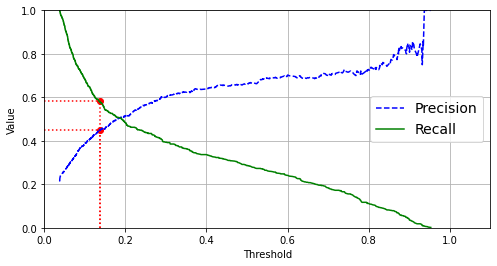

In [ ]:
precisions, recalls, thresholds = precision_recall_curve(y_valid, y_pred)
thrs, _ = better_threshold(precisions, recalls, thresholds)
plot_precision_recall_vs_threshold(precisions, recalls, thresholds, thrs)

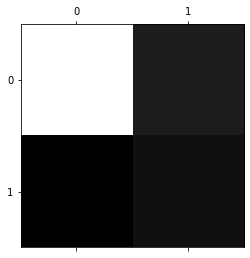

(0.45077720207253885, 0.508400292184076)

In [ ]:
y_hired = (y_pred>= thrs).astype(int)
evaluate(y_hired, y_valid)

## Ridge

In [ ]:
lgc = Ridge(random_state=42, alpha=1.).fit(X_train, y_train)
y_pred = lgc.predict(X_valid)

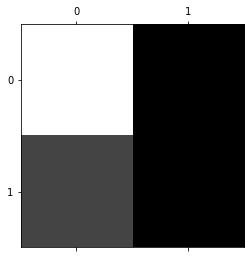

(0.0, 0.0)

In [ ]:
y_hired = (y_pred>= 0.5).astype(int)
evaluate(y_hired, y_valid)

## LGBM

In [ ]:
mdl = LGBMClassifier(n_estimators=300, random_state=42)
mdl.fit(X_train, y_train)
    
y_pred = mdl.predict_proba(X_valid)[:, 1]

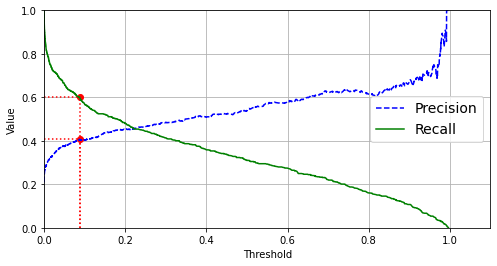

In [ ]:
precisions, recalls, thresholds = precision_recall_curve(y_valid, y_pred)
thrs, _ = better_threshold(precisions, recalls, thresholds)
plot_precision_recall_vs_threshold(precisions, recalls, thresholds, thrs)

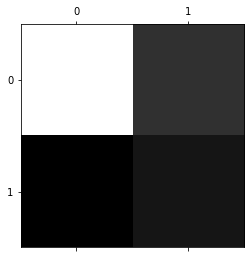

(0.4070294784580499, 0.4854631507775524)

In [ ]:
y_hired = (y_pred >= thrs).astype(int)
evaluate(y_hired, y_valid)

## Random Forest

In [ ]:
rf = RandomForestClassifier(n_estimators=700, random_state=42).fit(X_train, y_train)
y_pred = rf.predict_proba(X_valid)[:,1]

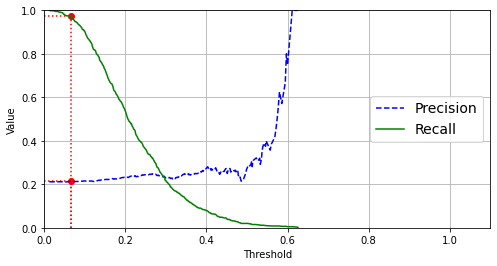

In [ ]:
precisions, recalls, thresholds = precision_recall_curve(y_valid, y_pred)
thrs, _ = better_threshold(precisions, recalls, thresholds)
plot_precision_recall_vs_threshold(precisions, recalls, thresholds, thrs)

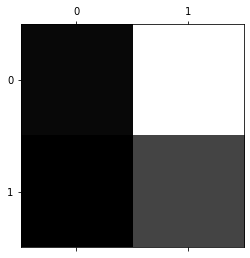

(0.2133676092544987, 0.35)

In [ ]:
y_hired = (y_pred >= thrs).astype(int)
evaluate(y_hired, y_valid)

## Neural Nets

In [ ]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    loss = f1_loss(y_true, y_pred)
    return 1 - loss

def f1_loss_(y_true, y_pred):
  precisions, recalls, thresholds = precision_recall_curve(y_true, y_pred)
  thrs, _ = better_threshold(precisions, recalls, thresholds)
  y = (y_pred >= thrs).astype(int)
  _, f1 = evaluate(y, y_true, plot_matrix=False)
  return 1 - f1

def f1_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, tf.float32), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), tf.float32), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, tf.float32), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), tf.float32), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plt.grid(True)
    plt.show()

In [ ]:
model = keras.models.Sequential([
    keras.Input(shape=X_train.shape[1]),
    keras.layers.Dense(19, activation="relu"),
    keras.layers.Dense(195, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])

In [ ]:
model.compile(loss=f1_loss,
             optimizer=keras.optimizers.Adam(lr=2.9210748185657167e-05),
             metrics=[f1_m,precision_m, recall_m])

In [ ]:
 history = model.fit(X_train, 
                    y_train, 
                    epochs=40, 
                    validation_data=(X_valid, y_valid),
                    verbose=1)

Epoch 1/40
142/142 [==============================] - 1s 4ms/step - loss: 0.7072 - f1_m: 0.2932 - precision_m: 0.1981 - recall_m: 1.0000 - val_loss: 0.6938 - val_f1_m: 0.3077 - val_precision_m: 0.2132 - val_recall_m: 1.0000
Epoch 2/40
142/142 [==============================] - 0s 2ms/step - loss: 0.6988 - f1_m: 0.2996 - precision_m: 0.1967 - recall_m: 0.9930 - val_loss: 0.6871 - val_f1_m: 0.3145 - val_precision_m: 0.2132 - val_recall_m: 1.0000
Epoch 3/40
142/142 [==============================] - 0s 3ms/step - loss: 0.6891 - f1_m: 0.3105 - precision_m: 0.1974 - recall_m: 1.0000 - val_loss: 0.6803 - val_f1_m: 0.3213 - val_precision_m: 0.2132 - val_recall_m: 1.0000
Epoch 4/40
142/142 [==============================] - 0s 3ms/step - loss: 0.6817 - f1_m: 0.3187 - precision_m: 0.1981 - recall_m: 0.9859 - val_loss: 0.6737 - val_f1_m: 0.3279 - val_precision_m: 0.2132 - val_recall_m: 1.0000
Epoch 5/40
142/142 [==============================] - 0s 3ms/step - loss: 0.6697 - f1_m: 0.3307 - precis

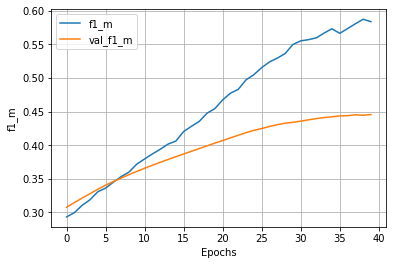

In [ ]:
plot_graphs(history, 'f1_m')

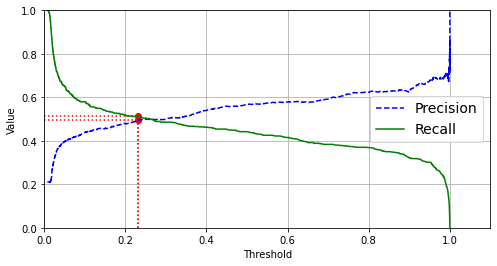

In [ ]:
y_pred = model.predict(X_valid)
y_pred = transform_1d_array(y_pred)
precisions, recalls, thresholds = precision_recall_curve(y_valid, y_pred)
thrs, _ = better_threshold(precisions, recalls, thresholds)
plot_precision_recall_vs_threshold(precisions, recalls, thresholds, thrs)

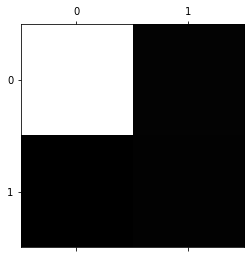

(0.4959481361426256, 0.5041186161449752)

In [ ]:
y_hired = (y_pred >= thrs).astype(int)
evaluate(y_hired, y_valid)

In [ ]:
y_pred = model.predict(X_test)
y_hired = (y_pred >= thrs).astype(int)

In [ ]:
submission = pd.DataFrame({'id': test_id, 'predicted': transform_1d_array(y_hired)})
submission.to_csv(PATH + 'Submissions/stack_nn_19_195_2.9210748185657167e-05.csv', index=False)

In [ ]:
def tune_nn(params):
  hidden1, learning_rate = params
  model = keras.models.Sequential([
    keras.Input(shape=X_train.shape[1]),
    keras.layers.Dense(hidden1, activation="relu"),
    # keras.layers.Dense(hidden2, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
  ])
  model.compile(loss=f1_loss,
             optimizer=keras.optimizers.Adam(lr=learning_rate),
             metrics=[f1_m,precision_m, recall_m])
    
  history = model.fit(X_train, 
                    y_train, 
                    epochs=20, 
                    validation_data=(X_valid, y_valid),
                    verbose=0)
  p = model.predict(X_valid)
  y_pred = transform_1d_array(p)
  precisions, recalls, thresholds = precision_recall_curve(y_valid, y_pred)
  thrs, _ = better_threshold(precisions, recalls, thresholds)
  y_pred = (y_pred >= thrs).astype(int)
  _, metric = evaluate(y_pred, y_valid, plot_matrix=False)

  print(params, metric)
  print()
  return -metric

In [ ]:
space = [(10, 200),
        #  (10, 200),
         (1e-5, 1e-3, 'log-uniform')]


res = gp_minimize(tune_nn, space, random_state=42, verbose=1, n_calls=30)

Iteration No: 1 started. Evaluating function at random point.
[161, 2.3273922280628698e-05] 0.5887445887445888

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 11.2725
Function value obtained: -0.5887
Current minimum: -0.5887
Iteration No: 2 started. Evaluating function at random point.
[158, 0.0001562069367563987] 0.5931156222418359

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 66.4489
Function value obtained: -0.5931
Current minimum: -0.5931
Iteration No: 3 started. Evaluating function at random point.
[95, 1.584710121043908e-05] 0.5884383088869715

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 11.2458
Function value obtained: -0.5884
Current minimum: -0.5931
Iteration No: 4 started. Evaluating function at random point.
[97, 4.649617447336329e-05] 0.5916955017301039

Iteration No: 4 ended. Evaluation done at random point.
Time taken: 7.2243
Function value obtained: -0.5917
Current minimum: -0.5931
Iteration No: 5 starte

* 2 hidden layers: [19, 195, 2.9210748185657167e-05] -> 0.5960378983634799

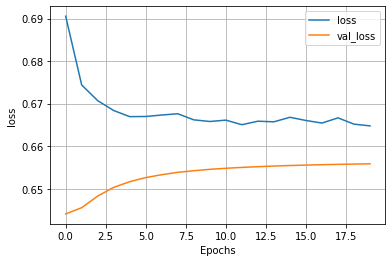

In [ ]:
plot_graphs(history, 'loss')

In [ ]:
model.predict(X_valid)

array([[0.99999946],
       [1.        ],
       [1.        ],
       ...,
       [1.        ],
       [1.        ],
       [1.        ]], dtype=float32)

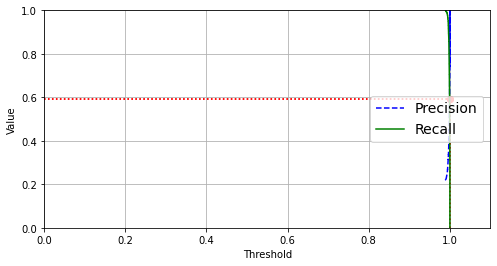

In [ ]:
y_pred = model.predict(X_valid)
y_pred = transform_1d_array(y_pred)
precisions, recalls, thresholds = precision_recall_curve(y_valid, y_pred)
thrs, _ = better_threshold(precisions, recalls, thresholds)
plot_precision_recall_vs_threshold(precisions, recalls, thresholds, thrs)

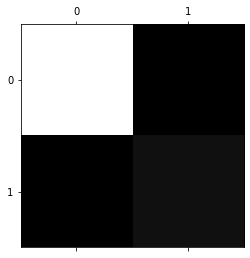

(0.592964824120603, 0.592964824120603)

In [ ]:
y_hired = (y_pred >= thrs).astype(int)
evaluate(y_hired, y_valid)

# Features selection

In [ ]:
X_train = pd.read_csv("{}preprocessed_data/approachs/train.csv".format(PATH))
X_valid = pd.read_csv("{}preprocessed_data/approachs/valid.csv".format(PATH))
X_test = pd.read_csv("{}preprocessed_data/approachs/test.csv".format(PATH))

In [ ]:
y_train = X_train["y"].astype(np.float32)
y_valid = X_valid["y"].astype(np.float32)
test_id = X_test["id"]
X_train.drop(["y"], axis=1, inplace=True)
X_valid.drop(["y"], axis=1, inplace=True)
X_test.drop(["id"], axis=1, inplace=True)

In [ ]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from itertools import combinations
from sklearn.model_selection import train_test_split
from boruta import BorutaPy
from sklearn.feature_selection import SelectFromModel, SequentialFeatureSelector, RFECV
class FeatureImportance_:

    def __init__(self):
        self.feature_selection = None

    def result(self, X, y):

        print("Variable Importance")
        clf = RandomForestClassifier(max_depth=2, random_state=42)

        clf.fit(X, y)

        res_var_imp = pd.DataFrame({
            "feature": X.columns,
            "var_imp": clf.feature_importances_
        })

        print("Mutual Information")
        mutual_info = mutual_info_classif(X, y)
        res_mutual_info = pd.DataFrame({
            "feature": X.columns,
            "mutual_info": mutual_info
        })

        print("Zero Proportion")
        res_pzeros = pd.DataFrame({
            "feature": X.columns,
            "pzeros": (X.shape[0] - X.astype(bool).sum(axis=0)) / X.shape[0] * 100
        })

        print("Null proporcion")
        res_pnull = pd.DataFrame({
            "feature": X.columns,
            "pnull": 100 - (X.shape[0] - X.replace(-999, np.nan).isnull().sum()) / X.shape[0] * 100
        })

        print("Backward Feature Elimination")
        lasso_newton = LogisticRegression(C=1, penalty="l2", solver='sag', tol = 0.1, random_state=42)
        bfs = SequentialFeatureSelector(lasso_newton,
                                            direction='backward',
                                            scoring='f1',
                                            cv=2,
                                            n_jobs=-1)
        bfs.fit(X, y)

        res_bfs = pd.DataFrame({
            "feature": X.columns,
            "bfs": ["to_keep" if bfs.support_[i] else "to_remove" for i in range(X.columns.shape[0])]
        })


        print("Lasso Regularization (L1)")
        lasso = LogisticRegression(C=1, penalty="l1", solver="liblinear", random_state=314).fit(X, y)
        lasso_selector = SelectFromModel(lasso, prefit=True, threshold="median")

        res_lasso = pd.DataFrame({
            "feature": X.columns,
            "lasso": np.where(lasso_selector.get_support(), "to_keep", "to_remove")
        })

        print("RFE")
        rf = RandomForestClassifier(n_jobs=-1, max_depth=4)
        rfe_selector = RFECV(rf, min_features_to_select=20, step=1, n_jobs=1, verbose=1)
        rfe_selector.fit(X.values, y)

        res_rfe = pd.DataFrame({
            "feature": X.columns,
            "rfe": np.where(rfe_selector.support_, "to_keep", "to_remove")
        })

        print("Boruta")
        rf = RandomForestClassifier(n_jobs=-1, max_depth=4)
        boruta_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=314)
        boruta_selector.fit(X.values, y)

        res_boruta = pd.DataFrame({
            "feature": X.columns,
            "boruta": np.where(boruta_selector.support_, "to_keep", "to_remove")
        })

        print("Random Column")
        X_random = X.copy()
        X_random['random'] = np.random.uniform(0.0, 100.0, size=X.shape[0])

        rf = RandomForestClassifier(n_jobs=-1, max_depth=3)
        rf.fit(X_random, y)

        varip_random = np.float(rf.feature_importances_[X_random.columns=="random"])

        res_rand_var_imp = pd.DataFrame({
            "feature": X_random.columns,
            "rand_var_imp": rf.feature_importances_,
            "rand_var": np.where(rf.feature_importances_ > varip_random, "to_keep", "to_remove")
        })
        feature_selection = res_var_imp.\
                                merge(res_mutual_info).\
                                merge(res_pzeros).\
                                merge(res_pnull).\
                                merge(res_bfs).\
                                merge(res_lasso).\
                                merge(res_boruta).\
                                merge(res_rfe).\
                                merge(res_rand_var_imp.drop('rand_var_imp', axis=1))

        return feature_selection.style.\
                bar(subset=['var_imp'],color='#205ff2').\
                bar(subset=['mutual_info'],color='#205ff2').\
                background_gradient(subset=['pzeros'],cmap='coolwarm').\
                background_gradient(subset=['pnull'],cmap='coolwarm').\
                apply(lambda x: ["background: red" if v == "to_remove" else "" for v in x], axis = 1)

In [ ]:
X = pd.concat([X_train, X_valid], axis=0)
y = pd.concat([y_train, y_valid], axis=0)
ftr_impo = FeatureImportance_()
ftr_impo.result(X, y)

Variable Importance
Mutual Information
Zero Proportion
Null proporcion
Backward Feature Elimination
